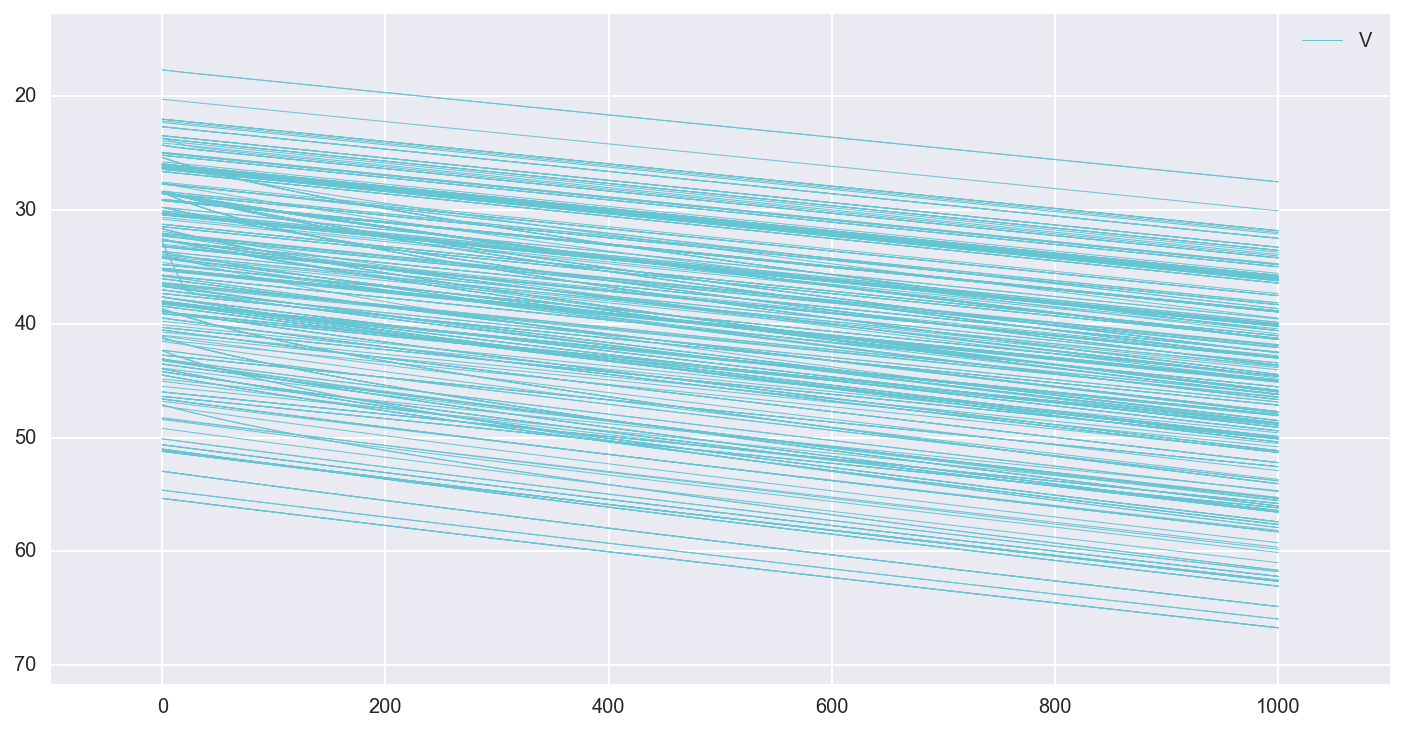

Preparing corner plot, takes some time.


ValueError: It looks like the parameter(s) in column(s) 1 have no dynamic range. Please provide a `range` argument.

In [33]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import corner
import json
import matplotlib.pyplot as plt
import numpy as np
from mosfit.plotting import bandcolorf

with open('../products/walkers.json', 'r') as f:
    data = json.loads(f.read())
    
# Find best scoring walker
if 'score' in data['0']:
    real_data = True
    max_score = max([data[x]['score'] for x in data])
    print('Highest score: ' + str(max_score))
    for x in data:
        if data[x]['score'] == max_score:
            bdata = data[x]
            break
else:
    real_data = False
    bdata = data['0']
band_names = list(set(bdata['bands']))

fig = plt.figure(figsize=(12,6))
used_bands = []
for band in band_names:
    for walk in data:
        bdata = data[walk]
        xs, ys = zip(*[
            [x, y] for x, y, z in
            zip(bdata['times'], bdata['model_magnitudes'], bdata['bands'])
            if z == band])
        label = '' if real_data or band in used_bands else band
        plt.plot(xs, ys, c=bandcolorf(band), label=label, linewidth=0.5)
        used_bands = list(set(used_bands + [band]))
    if real_data:
        xs, ys, yes = zip(*[
            [x, y, ye] for x, y, ye, z in
            zip(bdata['times'], bdata['magnitudes'], bdata['e_magnitudes'], bdata['bands'])
            if z == band])
        plt.errorbar(xs, ys, yerr=yes, color=bandcolorf(band), fmt='o',
                     label=(band if band not in used_bands else ''),
                     markeredgecolor='black', markeredgewidth=1, capsize=5,
                     elinewidth=2, capthick=2, zorder=10)
        plt.errorbar(xs, ys, yerr=yes, color='k', fmt='o', capsize=6,
                     elinewidth=3, capthick=3, zorder=5)
plt.gca().invert_yaxis()
plt.margins(0.1,0.1)
plt.legend()
plt.show()
fig.savefig('../products/lc.pdf')

# Construct walker arrays for corner
print('Preparing corner plot, takes some time.')
corner_input = []
for w in data:
    pars = data[w]['parameters']
    var_names = ['$' + ('\\log\\, ' if pars[x]['log'] else '') +
                 pars[x]['latex'] + '$' for x in pars]
    corner_input.append([np.log10(pars[x]['value']) if
                         pars[x]['log'] else pars[x]['value'] for x in pars])
cfig = corner.corner(corner_input, labels=var_names)
cfig.savefig('../products/corner.pdf')